In [1]:
import pandas as pd
import numpy as np
import branched_resnet_v2 as br
from torchvision import transforms

# Load saved dataset artifact (.npz) and configure for training
npz_path = 'data/multi_cancer/adenocarcinoma_dataset.npz'
data = np.load(npz_path)

# Extract arrays
images = data['images']                 # (N, H, W, 3) or (N, H, W)
labels1 = data['labels1'].astype(np.int64)  # primary labels (e.g., class ids)
labels2 = data['labels2'].astype(np.int64)  # secondary labels (e.g., domain/binary)

# Text metadata aligned 1:1 with dataset
domain_text_list = data['domain_text'].astype(str).tolist()
sub_domain_text_list = data['sub_domain_text'].astype(str).tolist()

# Define transform appropriate for RGB arrays (no grayscale channel repeat)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Build dataset compatible with the training pipeline
dataset = br.CustomImageDataset(images=images, labels1=labels1, labels2=labels2, transform=transform)

# Quick sanity check
print('Loaded shapes:', images.shape, labels1.shape, labels2.shape)
sample = dataset[0]
print({k: (v.shape if hasattr(v, 'shape') else v) for k, v in sample.items()})
print('domain_text[0]:', domain_text_list[0])
print('sub_domain_text[0]:', sub_domain_text_list[0])


Loaded shapes: (45000, 224, 224, 3) (45000,) (45000,)
{'pixel_values': torch.Size([3, 224, 224]), 'labels1': 15, 'labels2': 0}
domain_text[0]: Lung and Colon Cancer
sub_domain_text[0]: colon_bnt
Loaded shapes: (45000, 224, 224, 3) (45000,) (45000,)
{'pixel_values': torch.Size([3, 224, 224]), 'labels1': 15, 'labels2': 0}
domain_text[0]: Lung and Colon Cancer
sub_domain_text[0]: colon_bnt


In [2]:
import torch

print(torch.__version__)

# Set device and verify CUDA availability
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(f'Using device: {device}')

2.6.0+cu118
CUDA available: True
CUDA version: 11.8
Device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 4070
Using device: cuda


In [3]:
# Split dataset into train/val/test while keeping domain and subdomain text aligned
from typing import List, Optional, Tuple
import numpy as np

try:
    # Prefer v2 dataset class if available
    from branched_resnet_v2 import CustomImageDataset
except Exception:
    from branched_resnet import CustomImageDataset


def _per_class_split(idxs: List[int], ratios: Tuple[float, float, float], rng: np.random.Generator):
    idxs = list(idxs)
    rng.shuffle(idxs)
    n = len(idxs)
    t_ratio, v_ratio, s_ratio = ratios
    # initial floors
    n_train = int(np.floor(t_ratio * n))
    n_val = int(np.floor(v_ratio * n))
    n_test = n - n_train - n_val
    # guard against negatives due to rounding
    if n_test < 0:
        n_test = 0
        n_val = min(n_val, n - n_train)
    train = idxs[:n_train]
    val = idxs[n_train:n_train + n_val]
    test = idxs[n_train + n_val:]
    return train, val, test


def split_dataset_with_text(
    dataset: CustomImageDataset,
    domain_text_list: List[str],
    sub_domain_text_list: List[str],
    train_size: float = 0.7,
    val_size: float = 0.15,
    test_size: float = 0.15,
    stratify_on: Optional[str] = "labels1",  # 'labels1', 'labels2', or None
    shuffle: bool = True,
    seed: int = 42,
):
    """
    Split a CustomImageDataset into train/val/test while preserving alignment with
    domain_text_list and sub_domain_text_list.

    - stratify_on: 'labels1', 'labels2', or None for random split.
    - Returns: (train_ds, val_ds, test_ds, train_domain, val_domain, test_domain, train_sub, val_sub, test_sub)
    """
    N = len(dataset)
    if not np.isclose(train_size + val_size + test_size, 1.0):
        raise ValueError("train_size + val_size + test_size must sum to 1.0")

    # Coerce to arrays for indexing
    domain_text_arr = np.asarray(domain_text_list)
    sub_text_arr = np.asarray(sub_domain_text_list)
    if len(domain_text_arr) != N or len(sub_text_arr) != N:
        raise ValueError("domain_text_list and sub_domain_text_list must match dataset length")

    rng = np.random.default_rng(seed)

    # Choose indices by stratification or random
    if stratify_on in ("labels1", "labels2"):
        labels = np.asarray(getattr(dataset, stratify_on)).reshape(-1)
        # bucket indices by label value
        buckets = {}
        for i, lab in enumerate(labels):
            buckets.setdefault(int(lab), []).append(i)
        train_idx, val_idx, test_idx = [], [], []
        ratios = (train_size, val_size, test_size)
        for _, idxs in buckets.items():
            t, v, s = _per_class_split(idxs, ratios, rng)
            train_idx.extend(t)
            val_idx.extend(v)
            test_idx.extend(s)
        # optional shuffle within each split for randomness
        if shuffle:
            rng.shuffle(train_idx)
            rng.shuffle(val_idx)
            rng.shuffle(test_idx)
    else:
        all_idx = np.arange(N)
        if shuffle:
            rng.shuffle(all_idx)
        n_train = int(np.floor(train_size * N))
        n_val = int(np.floor(val_size * N))
        train_idx = all_idx[:n_train]
        val_idx = all_idx[n_train:n_train + n_val]
        test_idx = all_idx[n_train + n_val:]

    # Helper to build subset dataset preserving the original transform
    def build_subset(indices):
        images = dataset.images[indices]
        labels1 = dataset.labels1[indices]
        labels2 = dataset.labels2[indices]
        return CustomImageDataset(images=images, labels1=labels1, labels2=labels2, transform=getattr(dataset, 'transform', None))

    train_ds = build_subset(train_idx)
    val_ds = build_subset(val_idx)
    test_ds = build_subset(test_idx)

    train_domain = domain_text_arr[train_idx].tolist()
    val_domain = domain_text_arr[val_idx].tolist()
    test_domain = domain_text_arr[test_idx].tolist()

    train_sub = sub_text_arr[train_idx].tolist()
    val_sub = sub_text_arr[val_idx].tolist()
    test_sub = sub_text_arr[test_idx].tolist()

    return (
        train_ds, val_ds, test_ds,
        train_domain, val_domain, test_domain,
        train_sub, val_sub, test_sub,
    )

In [4]:
# Example usage (adjust variable names to your notebook context)
# Assumes you have variables: dataset (CustomImageDataset), domain_text_list, sub_domain_text_list
# If your variables are different, replace them accordingly.
try:
    dataset
    domain_text_list
    sub_domain_text_list
except NameError:
    print("Define 'dataset', 'domain_text_list', and 'sub_domain_text_list' before running this cell.")
else:
    (
        train_ds, val_ds, test_ds,
        train_domain, val_domain, test_domain,
        train_sub, val_sub, test_sub,
    ) = split_dataset_with_text(
        dataset=dataset,
        domain_text_list=domain_text_list,
        sub_domain_text_list=sub_domain_text_list,
        train_size=0.7,
        val_size=0.15,
        test_size=0.15,
        stratify_on="labels1",  # or 'labels2' or None
        shuffle=True,
        seed=42,
    )

    print(
        "train/val/test sizes:", len(train_ds), len(val_ds), len(test_ds),
        "\ntrain sample domain/sub:", train_domain[0] if len(train_domain) else None, 
        ",", train_sub[0] if len(train_sub) else None,
    )

train/val/test sizes: 31500 6750 6750 
train sample domain/sub: Lung and Colon Cancer , lung_scc


In [ ]:
from transformers import Trainer, TrainingArguments, set_seed
import datetime

DATE = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Set output directory
output_dir = f'./data/AC_results/'

# Set Hyperparameters
NUM_EPOCHS = 50
lr = 0.1
OPTIM = 'sgd'
WEIGHT_DECAY = 1e-4
SEED = 42

# Set seed
torch.manual_seed(SEED)
set_seed(SEED)

def run_experiment(lambda_scheduler, from_checkpoint=None):
    # Derive class counts from loaded data to avoid label-out-of-range CUDA errors
    num_d1_classes = int(np.max(dataset.labels1)) + 1
    num_d2_classes = int(np.max(dataset.labels2)) + 1
    print(f"Using num_d1_classes={num_d1_classes}, num_d2_classes={num_d2_classes}")

    # Initialize model
    config = br.ResNetConfig()
    model = br.ResNetForMultiLabel(
        config=config,
        num_d1_classes=num_d1_classes,
        num_d2_classes=num_d2_classes,
        lamb=0,
    )

    scheduler_name = lambda_scheduler.__name__

    # Set training arguments
    training_args = TrainingArguments(
            output_dir=f"{output_dir}/{scheduler_name}_results_{DATE}",
            num_train_epochs=NUM_EPOCHS,
            per_device_train_batch_size=32,
            eval_strategy="epoch",
            save_strategy="epoch",
            logging_dir='./logs',
            logging_steps=10,
            load_best_model_at_end=True,
            learning_rate=lr,
            weight_decay=WEIGHT_DECAY,
            seed=SEED,
            optim=OPTIM
        )

    trainer = Trainer(
        model = model,
        args = training_args,
        train_dataset= train_ds,
        eval_dataset= val_ds,
        compute_metrics=br.make_metrics_fn(model),
        callbacks=[br.LambdaUpdateCallback(model, lambda_scheduler, NUM_EPOCHS)]
    )
    if from_checkpoint != None:
        trainer.train(resume_from_checkpoint=from_checkpoint)
    else:
        trainer.train()
        
    trainer.save_model(f"{output_dir}/{scheduler_name}_final_model_{DATE}")

    metrics = trainer.evaluate()

    return metrics

run_experiment(br.lambda_scheduler)

Using num_d1_classes=21, num_d2_classes=2


wandb: Currently logged in as: samuelsavine (samuelsavine-johns-hopkins-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
C:\Users\samue\AppData\Roaming\Python\Python311\site-packages\pydantic\main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
C:\Users\samue\AppData\Roaming\Python\Python311\site-packages\pydantic\main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'eval_loss': 0.8285849094390869,
 'eval_accuracy_branch1': 0.6635555555555556,
 'eval_precision_branch1': 0.6899337033345567,
 'eval_recall_branch1': 0.6635555555555555,
 'eval_f1_branch1': 0.6516338085421188,
 'eval_accuracy_branch2': 0.6805925925925926,
 'eval_precision_branch2': 0.728680199452692,
 'eval_recall_branch2': 0.6493333333333333,
 'eval_f1_branch2': 0.63498417236392,
 'eval_lambda': 0.9974579674738373,
 'eval_runtime': 11.9598,
 'eval_samples_per_second': 564.393,
 'eval_steps_per_second': 70.57,
 'epoch': 3.0}

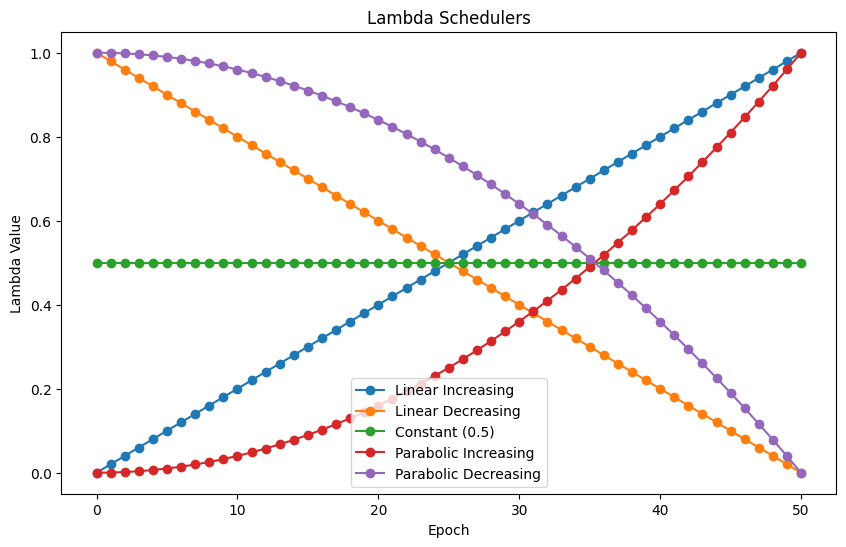

In [4]:
NUM_EPOCHS = 50

def linear_increasing_lambda_scheduler(epoch, total_epochs):
    return epoch / total_epochs

def linear_decreasing_lambda_scheduler(epoch, total_epochs):
    return 1 - (epoch / total_epochs)

def constant_lambda_scheduler(epoch=None, total_epochs=None, lambda_value=0.5):
    return lambda_value

def parabolic_increasing_lambda_scheduler(epoch, total_epochs, start_value=0.0, end_value=1.0):
    progress = epoch / total_epochs
    return start_value + (end_value - start_value) * (progress ** 2)

def parabolic_decreasing_lambda_scheduler(epoch, total_epochs, start_value=0.0, end_value=1.0):
    progress = epoch / total_epochs
    return end_value - (end_value - start_value) * (progress ** 2)

# Plot lambda schedulers
import matplotlib.pyplot as plt

epochs = np.arange(0, NUM_EPOCHS + 1)
linear_increasing = [linear_increasing_lambda_scheduler(e, NUM_EPOCHS) for e in epochs]
linear_decreasing = [linear_decreasing_lambda_scheduler(e, NUM_EPOCHS) for e in epochs]
constant = [constant_lambda_scheduler() for e in epochs]
parabolic_increasing = [parabolic_increasing_lambda_scheduler(e, NUM_EPOCHS) for e in epochs]
parabolic_decreasing = [parabolic_decreasing_lambda_scheduler(e, NUM_EPOCHS) for e in epochs]

plt.figure(figsize=(10, 6))
plt.plot(epochs, linear_increasing, label='Linear Increasing', marker='o')
plt.plot(epochs, linear_decreasing, label='Linear Decreasing', marker='o')
plt.plot(epochs, constant, label='Constant (0.5)', marker='o')
plt.plot(epochs, parabolic_increasing, label='Parabolic Increasing', marker='o')
plt.plot(epochs, parabolic_decreasing, label='Parabolic Decreasing', marker='o')
plt.title('Lambda Schedulers')
plt.xlabel('Epoch')
plt.ylabel('Lambda Value')
plt.legend()

In [5]:
# run_experiment(constant_lambda_scheduler, from_checkpoint="./data/D20_results/constant_lambda_scheduler_results_2025-09-14_21-38-10/checkpoint-73474")

run_experiment(constant_lambda_scheduler)

wandb: Currently logged in as: samuelsavine (samuelsavine-johns-hopkins-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
C:\Users\samue\AppData\Roaming\Python\Python311\site-packages\pydantic\main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'eval_loss': 0.8685183525085449,
 'eval_accuracy_branch1': 0.8672777692189185,
 'eval_precision_branch1': 0.8623934915674585,
 'eval_recall_branch1': 0.8067261954888058,
 'eval_f1_branch1': 0.7807780569758975,
 'eval_accuracy_branch2': 0.5053150516099214,
 'eval_precision_branch2': 0.5059879905679714,
 'eval_recall_branch2': 0.5053150516099214,
 'eval_f1_branch2': 0.4910149338925805,
 'eval_lambda': 0.5,
 'eval_runtime': 18.0636,
 'eval_samples_per_second': 718.684,
 'eval_steps_per_second': 89.849,
 'epoch': 50.0}

In [6]:
run_experiment(linear_increasing_lambda_scheduler)

Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'eval_loss': 0.7290458083152771,
 'eval_accuracy_branch1': 0.981743953165922,
 'eval_precision_branch1': 0.983193477429315,
 'eval_recall_branch1': 0.9800235965629139,
 'eval_f1_branch1': 0.9811657726488016,
 'eval_accuracy_branch2': 0.42012016638422434,
 'eval_precision_branch2': 0.40659506567198916,
 'eval_recall_branch2': 0.42012016638422434,
 'eval_f1_branch2': 0.39833996653258424,
 'eval_lambda': 0.98,
 'eval_runtime': 35.2722,
 'eval_samples_per_second': 368.052,
 'eval_steps_per_second': 46.014,
 'epoch': 50.0}

In [ ]:
# run_experiment(linear_decreasing_lambda_scheduler)

Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'eval_loss': 1.0212634801864624,
 'eval_accuracy_branch1': 0.7588969342166076,
 'eval_precision_branch1': 0.6778477597818499,
 'eval_recall_branch1': 0.6666558274793233,
 'eval_f1_branch1': 0.6429969322478322,
 'eval_accuracy_branch2': 0.522107533507934,
 'eval_precision_branch2': 0.5248490019073093,
 'eval_recall_branch2': 0.522107533507934,
 'eval_f1_branch2': 0.5085527940655191,
 'eval_lambda': 0.020000000000000018,
 'eval_runtime': 35.7826,
 'eval_samples_per_second': 362.802,
 'eval_steps_per_second': 45.357,
 'epoch': 50.0}

In [8]:
run_experiment(parabolic_increasing_lambda_scheduler)

Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'eval_loss': 0.7161515951156616,
 'eval_accuracy_branch1': 0.9871360345093206,
 'eval_precision_branch1': 0.9886359736787966,
 'eval_recall_branch1': 0.9870817672993136,
 'eval_f1_branch1': 0.9877059125731289,
 'eval_accuracy_branch2': 0.4952241565244184,
 'eval_precision_branch2': 0.2566126238581824,
 'eval_recall_branch2': 0.4952241565244184,
 'eval_f1_branch2': 0.3313391182360177,
 'eval_lambda': 0.9603999999999999,
 'eval_runtime': 31.0927,
 'eval_samples_per_second': 417.526,
 'eval_steps_per_second': 52.199,
 'epoch': 50.0}

In [ ]:
# run_experiment(parabolic_decreasing_lambda_scheduler)

Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'eval_loss': 1.1114422082901,
 'eval_accuracy_branch1': 0.672084424587891,
 'eval_precision_branch1': 0.5475202119754035,
 'eval_recall_branch1': 0.5597090916233468,
 'eval_f1_branch1': 0.5042387140937745,
 'eval_accuracy_branch2': 0.523340009243568,
 'eval_precision_branch2': 0.5296906558926209,
 'eval_recall_branch2': 0.523340009243568,
 'eval_f1_branch2': 0.4964113913512711,
 'eval_lambda': 0.03960000000000008,
 'eval_runtime': 30.9934,
 'eval_samples_per_second': 418.864,
 'eval_steps_per_second': 52.366,
 'epoch': 50.0}

In [ ]:
# run_experiment(br.lambda_scheduler)

Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'eval_loss': 0.7693543434143066,
 'eval_accuracy_branch1': 0.9668772146048374,
 'eval_precision_branch1': 0.9637369862779888,
 'eval_recall_branch1': 0.9586898924935846,
 'eval_f1_branch1': 0.9603375376658871,
 'eval_accuracy_branch2': 0.4374518564165768,
 'eval_precision_branch2': 0.4335388960522395,
 'eval_recall_branch2': 0.4374518564165768,
 'eval_f1_branch2': 0.4290480219657373,
 'eval_lambda': 0.9998891029505543,
 'eval_runtime': 24.9376,
 'eval_samples_per_second': 520.58,
 'eval_steps_per_second': 65.082,
 'epoch': 50.0}